# ASGI

ASGI (Asynchronous Server Gateway Interface) - спецификация, введенная для поддержки асинхронности в web-приложениях и web-фреймворках для Python.

Спецификация WSGI предполагает, что экземпляр приложения будет написан с помощью синхронных вызовов, что для протокола HTTP подходит в достаточной мере, так как модель взаимодействия в HTTP предполагает отправку запроса с клиента на сервер, затем его обработку на сервере, и только потом отправку клиенту сформированного сервером ответа. На этом сеанс связи по протоколу HTTP считается оконченным.

Отчасти WebSocket использует протокол HTTP в качестве протокола нижнего уровня, однако HTTP является в некотором смысле полудуплексным протоколом, то есть клиент и сервер "говорят" по очереди.

WebSocket же является полнодуплексным протоколом, в котором сервер и клиент могут отправлять и читать данные в\из канала независимо от того что происходит с другой стороны. Кроме того, в отличие от завершения сессии в HTTP после отправки ответа сервером, соединение по протоколу WebSocket не будет закрыто и возможность отправки\получения данных сохранится, пока одна из сторон явно не разорвет соединение (или TCP-сокет не перейдет в закрытое состояние по соответствующим причинам).

WSGI не может в полной мере реализовать общение по протоколу WebSocket, поскольку использование синхронных методов потребует введения очередности (полудуплекса), и для каждого подключенного клиента придется держать отдельный поток для обработки событий сокета.

Только асинхронная модель программирования способна без существенных издержек справиться с параллельной обработкой WebSocket-соединений.

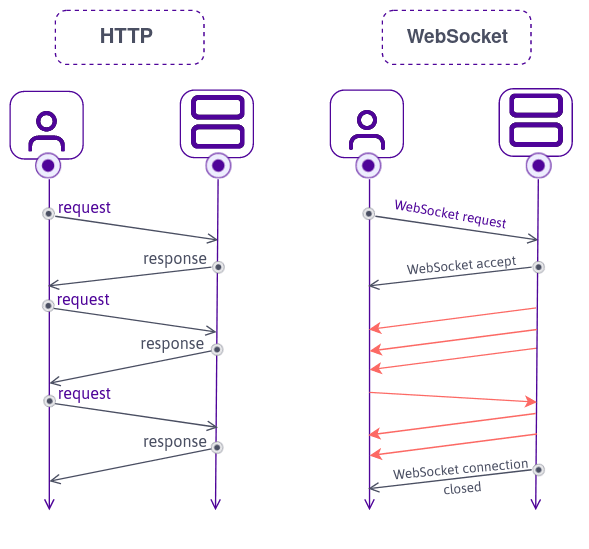

Актуальня документация и спецификация: https://asgi.readthedocs.io/en/latest/

Итог:
- WSGI - только синхронные обработчики протокола HTTP
- ASGI - асинхронные обработчики, поддерживается протокол HTTP и WebSocket

ASGI-приложения строятся с ипользованием модуля ```asyncio``` из стандартной библиотеки Python.

В спецификации ASGI приложение получает в качестве аргументов 3 значения:
- ```scope``` - словарь с переменными окружения
- ```send``` - асинхронный метод записи данных в канал
- ```receive``` - асинхронный метод чтения из канала

In [5]:
from typing import Callable

async def asgi_app(scope: dict, send: Callable, receive: Callable):
    data = await receive()
    # app logics
    await send(...)
    await send(...)

## Реализация ASGI HTTP сервера

Основная идея ASGI заключается в использовании неблокирующего сетевого ввода-вывода, который предоставляет модуль ```asyncio```.

На картинке ниже указана логическая схема ASGI-сервера:
- Основной поток прослушивает входящие соединения
- Каждый клиентский сокет передается в корутину-обработчик соединения
- Обработчик парсит запрос, вызывает приложение, формирует и отправляет ответ
- На каждом этапе сетевого взаимодействия (записи\чтения в\из сокета) корутина отдает управление (т.к. запись и чтение - блокирующие операции) и в этот момент другая корутина из цикла событий может быть запущена на выполенение
- Операционная система обеспечивает отбор сокетов, готовых к чтению\записи через системные вывозы (select\poll\epoll)
- Таким образом каждый клиент и обработка его запроса существует в рамках отдельного асинхронного контекста

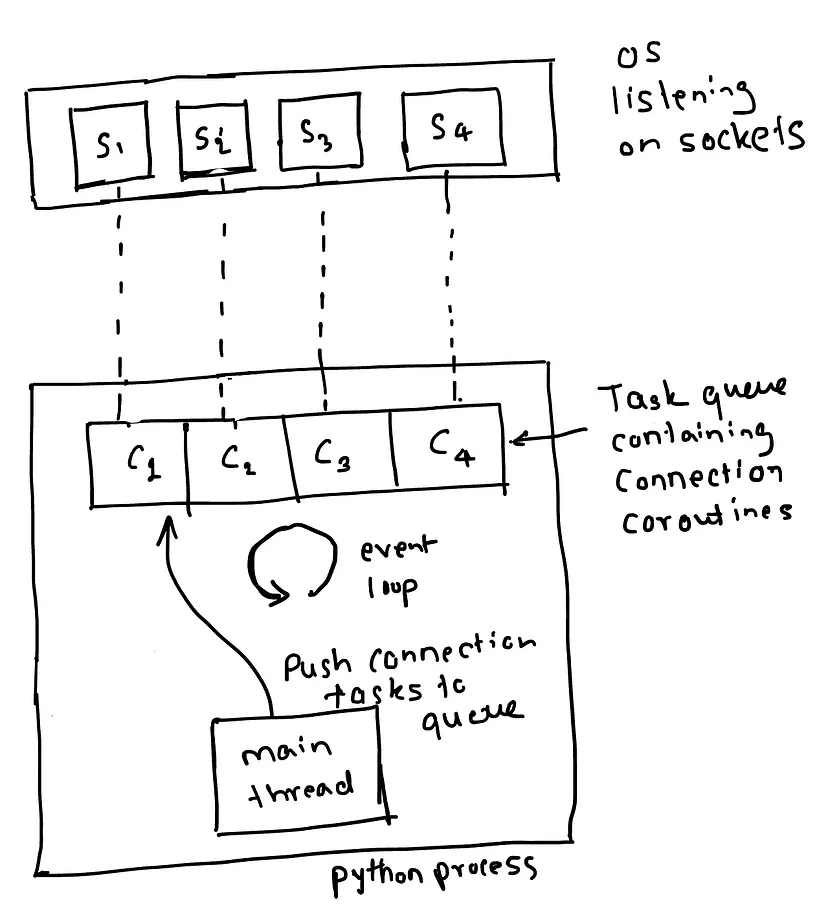

Реализуем класс Server, который будет принимать callable нашего приложения, и запускать серверный сокет на прослушивание.

При поступлении нового соединения сервер будет передавать работу классу-обработчику подключений, запуская задачу в цикле событий.

In [17]:
class Server:
    def __init__(self, app, host, port):
        self.app = app
        self.host = host
        self.port = port
        # Устанавливаем параметры сокета
        self.server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.server_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.server_socket.setblocking(False)
        self.server_socket.bind((self.host, self.port))

    async def listen_for_connections(self, loop):
        # Запускаем прослушивание сокета
        self.server_socket.listen()
        print(f"Listening on {self.host, self.port}")
        while True:
            connection, address = await loop.sock_accept(self.server_socket)
            print(f"{address} connected")
            connection_handler = ConnectionHandler(self.app, connection, loop)
            asyncio.create_task(connection_handler.handle_connection())

    async def start(self):
        loop = asyncio.get_event_loop()
        await self.listen_for_connections(loop)

Обработчик соединений:
- Примет callable приложения и клиентский сокет
- Распрасит HTTP-запрос
- Вызовет callable приложения
- Будет ожидать завершения работы приложения через примитив синхронизации ```asyncio.Event```

In [16]:
class ConnectionHandler:
    def __init__(self, app, connection, loop):
        self.app = app
        self.connection = connection
        self.loop = loop
        self.parser = HTTPparser()

    async def handle_connection(self):
        try:
            # Читаем данные из сокета
            data = await self.loop.sock_recv(self.connection, 1024)
            # Парсим запрос
            self.parser.parse_request(data)
            # Класс ASGISpec будет передавать нашему приложению методы send и receive
            asgi_spec = ASGIspec(self.parser)
            # Запускаем в цикле событий задачу на обработку запроса нашим приложением
            t = asyncio.create_task(asgi_spec.run(self.app))
            # Ожидаем когда callable приложения закончит работу. Флаг будет установлен в классе ASGISpec
            await asgi_spec.response_event.wait()
            # Сериализуем ответ
            http_response = self.parser.serialize_http_response(asgi_spec.response)
            # Отправляем все данные в сокет
            await self.loop.sock_sendall(self.connection, http_response)

        except HttpParserError as e:
            print("Http parser exception...", e)
        except Exception as e:
            print(e)
        finally:
            self.connection.close()

Также нам понадобится парсер запроса и формирователь ответа

In [8]:
class HttpParserError(Exception):
    pass


class HTTPparser:
    def __init__(self):
        self.request = {}

    def parse_request(self, http_data):
        try:
            request, headers_body = http_data.split(b'\r\n', 1)
            self.request["method"], self.request["path"], type_version = request.split(b' ')
            *headers, self.request["body"] = headers_body.split(b'\r\n')
            self.request["type"], self.request["http_version"] = type_version.split(b'/')

            formatted_headers = []
            for header in headers:
                try:
                    key, val = header.split(b':', maxsplit=1)
                    val = val.strip()
                    formatted_headers.append((key, val))
                except Exception as e:
                    pass
            self.request["headers"] = formatted_headers

        except Exception as e:
            raise HttpParserError()

    def serialize_http_response(self, asgi_responses):
        http_response = b""
        headers = {}

        for response in asgi_responses:
            response_type = response.get("type")

            if response_type == "http.response.start":
                status_code = response.get("status", 200)
                http_response += f"HTTP/1.1 {status_code} OK\r\n".encode()

                for header in response.get("headers", []):
                    key, value = header
                    headers[key] = value

            elif response_type == "http.response.body":
                http_response += b"\r\n".join(
                    [f"{key.decode()}: {value.decode()}".encode() for key, value in headers.items()])
                http_response += b"\r\n\r\n" + response.get("body", b"")
        logging.info(f"send {http_response}")
        return http_response

Класс ASGISpec. С ним будет взаимодействовать callable нашего приложения.

In [15]:
class ASGIspec:
    def __init__(self, http_parse: HTTPparser):
        self.scope: dict = {
            'asgi': {
                'version': '3.0',
                'spec_version': '2.0'
            },
            'method': http_parse.request['method'].decode(),
            'type': http_parse.request['type'].decode().lower(),
            'http_version': http_parse.request['http_version'].decode(),
            'path': http_parse.request['path'].decode(),
            'headers': http_parse.request['headers'],
            'query_string': b'',
        }
        self.http_parse = http_parse.request
        self.response = []
        # Примитив синхронизации между двума корутинами. 
        # Клиенту не имеет смысла отправлять кусок ответа, поэтому мы будем дожидаться события об окончании работы приложения, 
        # и отошлем ответ только тогда, когда он появится
        self.response_event = asyncio.Event()

    async def run(self, app):
        await app(self.scope, self.receive, self.send)

    async def send(self, message):
        self.response.append(message)
        if message.get('type') == "http.response.body":
            # Отсылка запроса клиенту начнется как только появится тело ответа (оно, если присутствует, завершает любой HTTP-ответ)
            # Вызывая метод .set() мы разблокируем корутины, ожидающие установки флага на методе .wait()
            self.response_event.set()

    async def receive(self):
        message = {
            "type": "http.request",
            "body": self.http_parse['body'],
            "more_body": False,
        }
        return message

Пример приложения

In [ ]:
import asyncio
import logging

from otus_asgi_ws.asgi import Server

logging.basicConfig(level=logging.DEBUG)


async def asgi_app_example(scope, receive, send):
    data = await receive()
    logging.info(f"asgi_app_example received {data}")
    await send({
        "type": "http.response.start",
        "headers": [
            (b"Server", b"Otus-X-ASGI-Server"),
        ]
    })
    await send({
        "type": "http.response.body",
        "body": b"Hello World!"
    })

if __name__ == "__main__":
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    server = Server(asgi_app_example, "0.0.0.0", 8085)
    loop.create_task(server.start())
    loop.run_forever()

Проверка работоспособности (c помощью утилиты httpie).

```bash
$ http --verbose http://localhost:8085
GET / HTTP/1.1
Accept: */*
Accept-Encoding: gzip, deflate
Connection: keep-alive
Host: localhost:8085
User-Agent: HTTPie/3.2.2



HTTP/1.1 200 OK
Server: Otus-X-ASGI-Server

Hello World!
```

# Websockets

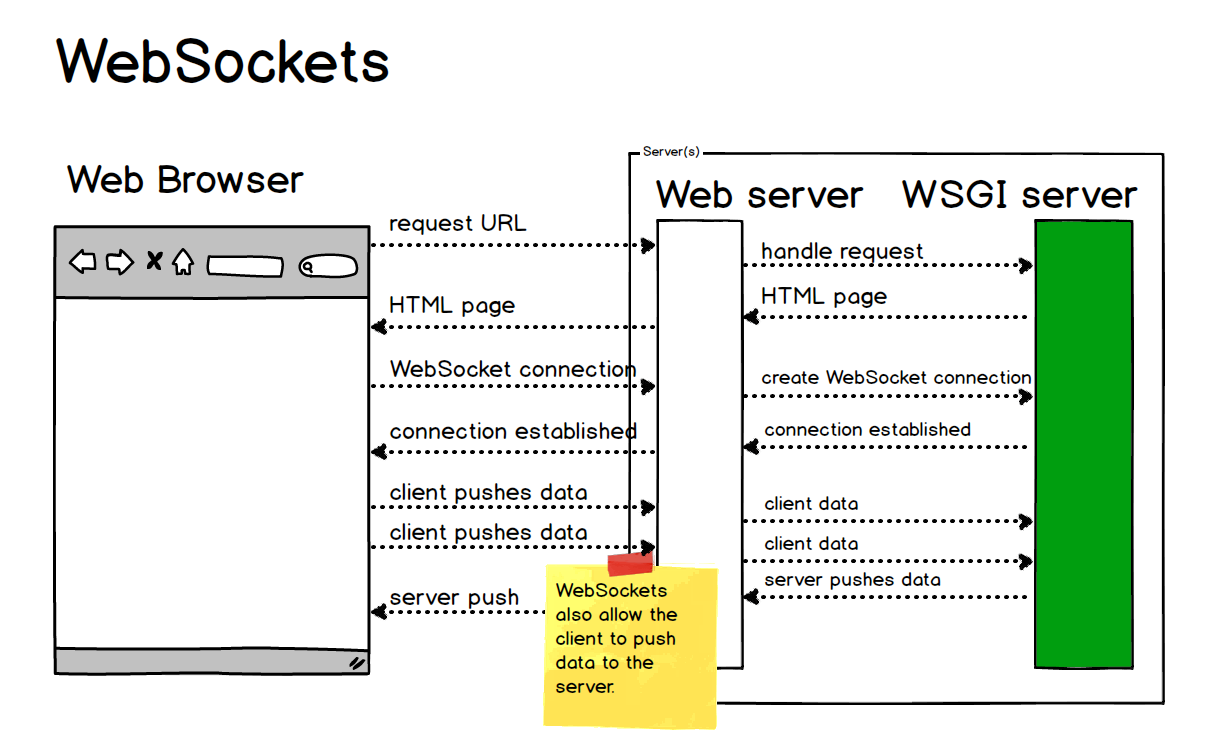

Ситуация с вебсокетами выглядит несколько посложнее из-за особенностей протокола.

Серверу требуется выполнить несколько действий, чтобы принять и поддержать соединение по WS-протоколу:
- Идентифицировать переход на общение по WS-протоколу
- Осуществить рукопожатие (handshake)
- Получить и декодировать фрейм
- Отправить фрейм

При переходе с HTTP-соединения на соединение по WS-протоколу клиент отправит серверу запрос

```
GET /chat HTTP/1.1
Host: example.com:8000
Upgrade: websocket
Connection: Upgrade
Sec-WebSocket-Key: dGhlIHNhbXBsZSBub25jZQ==
Sec-WebSocket-Version: 13
```

Следующие заголовки идентифицируют намерение клиента перейти на websocket
```
Upgrade: websocket
Connection: Upgrade
Sec-WebSocket-Key: dGhlIHNhbXBsZSBub25jZQ==
```

Далее нужно выполнить процедуру handshake, отправив на запрос ответ в виде:
```
HTTP/1.1 101 Switching Protocols
Upgrade: websocket
Connection: Upgrade
Sec-WebSocket-Accept: s3pPLMBiTxaQ9kYGzzhZRbK+xOo=
```

В данном случае ответ это такой же HTTP-ответ, однако в нем приуствтует заголовок ```Sec-WebSocket-Accept```, который вычисляется как sha-1 хэш от ключа, присланного клиентом в заголовке ```Sec-WebSocket-Key``` запроса и некоторого ключа на сервере.

```python
def shake_hand(self,key):
        # calculating response as per protocol RFC
        key = key + WS_MAGIC_STRING
        resp_key = base64.standard_b64encode(hashlib.sha1(key).digest())

        resp="HTTP/1.1 101 Switching Protocols\r\n" + \
             "Upgrade: websocket\r\n" + \
             "Connection: Upgrade\r\n" + \
             "Sec-WebSocket-Accept: %s\r\n\r\n"%(resp_key)
```

Передача данных по протоколу WebSocket в отличие от HTTP осуществляется не текстом, а пакетами специального формата

```
      0                   1                   2                   3
      0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1
     +-+-+-+-+-------+-+-------------+-------------------------------+
     |F|R|R|R| opcode|M| Payload len |    Extended payload length    |
     |I|S|S|S|  (4)  |A|     (7)     |             (16/64)           |
     |N|V|V|V|       |S|             |   (if payload len==126/127)   |
     | |1|2|3|       |K|             |                               |
     +-+-+-+-+-------+-+-------------+ - - - - - - - - - - - - - - - +
     |     Extended payload length continued, if payload len == 127  |
     + - - - - - - - - - - - - - - - +-------------------------------+
     |                               |Masking-key, if MASK set to 1  |
     +-------------------------------+-------------------------------+
     | Masking-key (continued)       |          Payload Data         |
     +-------------------------------- - - - - - - - - - - - - - - - +
     :                     Payload Data continued ...                :
     + - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - +
     |                     Payload Data continued ...                |
     +---------------------------------------------------------------+
```

Поэтому для каждого фрейма (пакета) потребуется распарсить его тело, вычислить длину данных, и вычитать их. Сборку пакета также потребуется провести при отправке на клиент.

In [ ]:
import socketserver as SocketServer
import hashlib
import base64

WS_MAGIC_STRING = b"258EAFA5-E914-47DA-95CA-C5AB0DC85B11"


class MyTCPHandler(SocketServer.BaseRequestHandler):

    def handle(self):
        # self.request is the TCP socket connected to the client
        self.data = self.request.recv(1024).strip()
        headers = self.data.split(b"\r\n")

        # is it a websocket request?
        if b"Connection: Upgrade" in self.data and b"Upgrade: websocket" in self.data:
            # getting the websocket key out
            for h in headers:
                if b"Sec-WebSocket-Key" in h:
                    key = h.split(b" ")[1]
        # let's shake hands shall we?
            self.shake_hand(key)

            while True:
                payload = self.decode_frame(bytearray(self.request.recv(1024).strip()))
                decoded_payload = payload.decode('utf-8')
                self.send_frame(payload)
                if "bye" == decoded_payload.lower():
                    "Bidding goodbye to our client..."
                    return
        else:
            self.request.sendall("HTTP/1.1 400 Bad Request\r\n" + \
                                 "Content-Type: text/plain\r\n" + \
                                 "Connection: close\r\n" + \
                                 "\r\n" + \
                                 "Incorrect request")

    def shake_hand(self,key):
        # calculating response as per protocol RFC
        key = key + WS_MAGIC_STRING
        resp_key = base64.standard_b64encode(hashlib.sha1(key).digest())

        resp=b"HTTP/1.1 101 Switching Protocols\r\n" + \
             b"Upgrade: websocket\r\n" + \
             b"Connection: Upgrade\r\n" + \
             b"Sec-WebSocket-Accept: %s\r\n\r\n"%(resp_key)

        self.request.sendall(resp)

    def decode_frame(self, frame):
        opcode_and_fin = frame[0]

        # assuming it's masked, hence removing the mask bit(MSB) to get len. also assuming len is <125
        payload_len = frame[1] - 128

        mask = frame [2:6]
        encrypted_payload = frame [6: 6+payload_len]

        payload = bytearray([ encrypted_payload[i] ^ mask[i%4] for i in range(payload_len)])

        return payload

    def send_frame(self, payload):
        # setting fin to 1 and opcpde to 0x1
        frame = [129]
        # adding len. no masking hence not doing +128
        frame += [len(payload)]
        # adding payload
        frame_to_send = bytearray(frame) + payload

        self.request.sendall(frame_to_send)


if __name__ == "__main__":
    HOST, PORT = "localhost", 9999

    # Create the server, binding to localhost on port 9999
    server = SocketServer.TCPServer((HOST, PORT), MyTCPHandler)
    server.serve_forever()

Также можно воспользоваться модулем WebSocket.

In [ ]:
# server.py

import asyncio
import websockets

async def handler(websocket):
    while True:
        try:
            message = await websocket.recv()
            print('Message received from client: ', message)
            await websocket.send("Message from server: " + message)
        except Exception as e:
            print(e)
            break

async def main():
    async with websockets.serve(handler, "", 8001):  # listen at port 8001
        await asyncio.Future()                       # run forever

if __name__ == "__main__":
    asyncio.run(main())

In [ ]:
# client.py

from websocket import create_connection

ws = create_connection("ws://localhost:8001")

while True:
    msg = input('Enter a message: ')
    if msg == 'quit':        
        ws.close()
        break
    ws.send(msg)
    result =  ws.recv()
    print ('> ', result)

## References

- https://medium.com/@rsalgare95/writing-an-asgi-server-from-scratch-and-using-it-with-fastapi-21ec1191f3c7
- https://github.com/python-websockets/websockets
- https://superuser.blog/websocket-server-python/
- https://medium.com/nuances-of-programming/%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-websocket-%D1%81-python-767722728ec6